# Information Globale

## Importation

In [1]:
#Générique Importation
import pandas as pd
import numpy as np
import seaborn as sns
import datetime

#Générique Importation
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error

#
from vacances_scolaires_france import SchoolHolidayDates

#Sclaing
from sklearn.preprocessing import RobustScaler

#Machine Learning
from sklearn.ensemble import HistGradientBoostingRegressor

from lineartree           import LinearBoostRegressor
from sklearn.linear_model import LinearRegression

#Vizualisation
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})


#Preprocessing Interne
from tilt.preproc_RTE import preprocessing_RTE_encours, preproc_temperature_ENEDIS, preproc_tempo
from tilt.preproc_RTE import add_schoolholidays, add_weekday, add_public_holidays


%load_ext autoreload
%autoreload 2

In [2]:
# Data Import
## Puissance
EnCours_Consolide = pd.read_csv("data/puissance/eCO2mix_RTE_En-cours-Consolide.csv",delimiter=";")
EnCours_Temps_R = pd.read_csv("data/puissance/eCO2mix_RTE_En-cours-TR.csv",delimiter=";")
Temp_Dep = pd.read_csv("data/temperature-quotidienne-departementale.csv",delimiter=";")
Temp_Nationale = pd.read_csv("data/donnees-de-temperature-et-de-pseudo-rayonnement.csv",delimiter=";")

Tempo_RTE_2122 = pd.read_csv("data/puissance/eCO2mix_RTE_tempo_2021-2022.csv",delimiter=";")
Tempo_RTE_2223 = pd.read_csv("data/puissance/eCO2mix_RTE_tempo_2022-2023.csv",delimiter=";")
Tempo_RTE_2324 = pd.read_csv("data/puissance/eCO2mix_RTE_tempo_2023-2024.csv",delimiter=";")

/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_4827/3326194778.py:3: DtypeWarning: Columns (36,37,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  EnCours_Consolide = pd.read_csv("data/puissance/eCO2mix_RTE_En-cours-Consolide.csv",delimiter=";")
/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_4827/3326194778.py:4: DtypeWarning: Columns (5,26,27,30,31,33,36,37,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  EnCours_Temps_R = pd.read_csv("data/puissance/eCO2mix_RTE_En-cours-TR.csv",delimiter=";")


## Explication Choix TR

J'ai souhaité prendre seumlement le TR pour deux raisons :
- on souhaite prédire pour le lendemain donc plus logique dans la démarceh d'utilisé les valeurs de la veille (ou de S-2 dans le cas de TILT)
- minimiser l'impact COVID, ça ne sert à rien de revenir trop en arrière à cause de l'effet COVID qui va influencer.

- TR : Temps Réel, donc mis à jour avec prévision et modléisation de ce que l'on peut récupérer
- Consolidé : Données consolidé avec échnages des différentes antennes.

## Analyse Pre-Données

In [3]:
EnCours_Temps_R.head()

,Périmètre,Nature,Date,Heures,Consommation,Prévision J-1,Prévision J,Fioul,Charbon,Gaz,...,Hydraulique - Lacs,Hydraulique - STEP turbinage,Bioénergies - Déchets,Bioénergies - Biomasse,Bioénergies - Biogaz,Stockage batterie,Déstockage batterie,Eolien terrestre,Eolien offshore,Unnamed: 40
0,France,Données temps réel,2022-06-01,00:00,44940.0,44800,45100.0,144.0,0.0,3596.0,...,1054,1677.0,170,584.0,286.0,ND,ND,ND,ND,NaN
1,France,Données temps réel,2022-06-01,00:15,43967.0,43700,43900.0,144.0,0.0,3716.0,...,1419,581.0,171,560.0,276.0,ND,ND,ND,ND,NaN
2,France,Données temps réel,2022-06-01,00:30,42514.0,42600,42700.0,142.0,0.0,2880.0,...,1280,530.0,169,561.0,276.0,ND,ND,ND,ND,NaN
3,France,Données temps réel,2022-06-01,00:45,41073.0,41450,41600.0,143.0,0.0,2699.0,...,1120,361.0,170,563.0,276.0,ND,ND,ND,ND,NaN
4,France,Données temps réel,2022-06-01,01:00,40359.0,40300,40500.0,144.0,3.0,2718.0,...,1101,373.0,170,563.0,276.0,ND,ND,ND,ND,NaN


In [4]:
EnCours_Temps_R[-230:].head(50)

,Périmètre,Nature,Date,Heures,Consommation,Prévision J-1,Prévision J,Fioul,Charbon,Gaz,...,Hydraulique - Lacs,Hydraulique - STEP turbinage,Bioénergies - Déchets,Bioénergies - Biomasse,Bioénergies - Biogaz,Stockage batterie,Déstockage batterie,Eolien terrestre,Eolien offshore,Unnamed: 40
57275,France,Données temps réel,2024-01-18,14:45,68208.0,67100,68200.0,190.0,9.0,8029.0,...,2845.0,830.0,74.0,355.0,248.0,-1.0,1.0,4363.0,278.0,NaN
57276,France,Données temps réel,2024-01-18,15:00,67868.0,66900,68100.0,190.0,10.0,7818.0,...,2612.0,1001.0,76.0,355.0,248.0,-4.0,0.0,4326.0,283.0,NaN
57277,France,Données temps réel,2024-01-18,15:15,67745.0,66650,67750.0,191.0,5.0,7892.0,...,2731.0,1071.0,76.0,353.0,248.0,-2.0,2.0,4140.0,292.0,NaN
57278,France,Données temps réel,2024-01-18,15:30,67143.0,66400,67400.0,190.0,5.0,7956.0,...,2709.0,1143.0,76.0,355.0,248.0,-2.0,1.0,4053.0,338.0,NaN
57279,France,Données temps réel,2024-01-18,15:45,NaN,66400,67250.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57280,France,Données temps réel,2024-01-18,16:00,NaN,66400,67100.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57281,France,Données temps réel,2024-01-18,16:15,NaN,66250,66850.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57282,France,Données temps réel,2024-01-18,16:30,NaN,66100,66600.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57283,France,Données temps réel,2024-01-18,16:45,NaN,66500,66750.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57284,France,Données temps réel,2024-01-18,17:00,NaN,66900,66900.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


On remarque que les lignes dépendent du moment de récupération du fichier (cf 23h30).
Mais que Prévision J fini à la journée même.

In [5]:
Temp_Dep.head()

,date_obs,code_insee_departement,departement,tmin,tmax,tmoy
0,2019-10-22,21,Côte-d'Or,10.90,16.00,13.45
1,2019-10-22,73,Savoie,11.70,18.65,15.18
2,2019-10-22,29,Finistère,7.77,15.48,11.63
3,2019-10-22,48,Lozère,9.70,16.50,13.10
4,2019-10-22,49,Maine-et-Loire,4.40,15.10,9.75


In [6]:
Temp_Nationale.head()

,horodate,temperature_realisee_lissee_degc,temperature_normale_lissee_degc,temperature_realisee_lissee_temperature_normale_lissee_degc,pseudo_rayonnement,annee,mois,jour,annee_mois_jour
0,2024-01-17T20:00:00+00:00,4.8,4.9,-0.1,28.0,2024,1,17,2024-01-17
1,2024-01-17T14:30:00+00:00,5.8,6.0,-0.2,8.0,2024,1,17,2024-01-17
2,2024-01-17T12:30:00+00:00,5.4,5.8,-0.4,4.0,2024,1,17,2024-01-17
3,2024-01-17T12:00:00+00:00,5.4,5.7,-0.3,3.0,2024,1,17,2024-01-17
4,2024-01-17T08:30:00+00:00,3.7,4.5,-0.8,11.0,2024,1,17,2024-01-17


In [7]:
Tempo_RTE_2324.head()

,Date,Type de jour TEMPO
0,2023-09-01,BLEU
1,2023-09-02,BLEU
2,2023-09-03,BLEU
3,2023-09-04,BLEU
4,2023-09-05,BLEU


Les offres de fourniture d'électricité de type Tempo comportent différents niveaux de prix, variables en fonction de l'heure et des jours de l'année.

- Les jours rouges correspondent aux périodes de l'année où la consommation est forte,
- Les jours blancs à un niveau intermédiaire,
- Les jours bleus sont ceux de plus faible consommation.


## Création Data

In [8]:
EnCours_Consolide_preprocessed = preprocessing_RTE_encours(EnCours_Temps_R)

/Users/arthurdubs/code/interview_test/tilt/tilt-interview-case/tilt/preproc_RTE.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['date_hour'] = pd.to_datetime(df_final['Date']+ " " + df_final['Heures'])
/Users/arthurdubs/code/interview_test/tilt/tilt-interview-case/tilt/preproc_RTE.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['Date'] = pd.to_datetime(df_final['Date'])
/Users/arthurdubs/code/interview_test/tilt/tilt-interview-case/tilt/preproc_RTE.py:18: SettingWithCopyWarning: 

In [9]:
EnCours_Consolide_preprocessed.head(5)

,Date,Heures,date_hour,Prévision J-1,Consommation
0,2022-06-01,00:00:00,2022-06-01 00:00:00,44800.0,44940.0
1,2022-06-01,00:15:00,2022-06-01 00:15:00,43700.0,43967.0
2,2022-06-01,00:30:00,2022-06-01 00:30:00,42600.0,42514.0
3,2022-06-01,00:45:00,2022-06-01 00:45:00,41450.0,41073.0
4,2022-06-01,01:00:00,2022-06-01 01:00:00,40300.0,40359.0


J'ai remarque en relecture qu'ajouter Prévision J-1/PrévisionJ pourrait être intéressant, à valider.

## Température Nationale

In [10]:
df_temp = preproc_temperature_ENEDIS(Temp_Nationale)

/Users/arthurdubs/code/interview_test/tilt/tilt-interview-case/tilt/preproc_RTE.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reduced['horodate'] = df_reduced['horodate'].map(lambda x : x[:-6])
/Users/arthurdubs/code/interview_test/tilt/tilt-interview-case/tilt/preproc_RTE.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reduced['horodate'] = pd.to_datetime(df_reduced['horodate'],utc=False)
/Users/arthurdubs/code/interview_test/tilt/tilt-interview-case/tilt/preproc_RTE.py:36: SettingWithCop

In [11]:
df_temp

,date_hour,temperature_realisee_lissee_degc,annee,mois,jour
76660,2019-01-17 23:00:00,5.3,2019,1,17
87647,2019-01-17 23:30:00,5.3,2019,1,17
43837,2019-01-18 00:00:00,5.3,2019,1,18
43836,2019-01-18 00:30:00,5.2,2019,1,18
76659,2019-01-18 01:00:00,5.2,2019,1,18
...,...,...,...,...,...
35472,2024-01-17 20:30:00,4.8,2024,1,17
35471,2024-01-17 21:00:00,4.8,2024,1,17
12131,2024-01-17 21:30:00,4.8,2024,1,17
35470,2024-01-17 22:00:00,4.8,2024,1,17


## Add Column

In [12]:
EnCours_Consolide_preprocessed = add_weekday(EnCours_Consolide_preprocessed)
EnCours_Consolide_preprocessed

,Date,Heures,date_hour,Prévision J-1,Consommation,weekday
0,2022-06-01,00:00:00,2022-06-01 00:00:00,44800.0,44940.0,2
1,2022-06-01,00:15:00,2022-06-01 00:15:00,43700.0,43967.0,2
2,2022-06-01,00:30:00,2022-06-01 00:30:00,42600.0,42514.0,2
3,2022-06-01,00:45:00,2022-06-01 00:45:00,41450.0,41073.0,2
4,2022-06-01,01:00:00,2022-06-01 01:00:00,40300.0,40359.0,2
...,...,...,...,...,...,...
57274,2024-01-18,14:30:00,2024-01-18 14:30:00,67300.0,67663.0,3
57275,2024-01-18,14:45:00,2024-01-18 14:45:00,67100.0,68208.0,3
57276,2024-01-18,15:00:00,2024-01-18 15:00:00,66900.0,67868.0,3
57277,2024-01-18,15:15:00,2024-01-18 15:15:00,66650.0,67745.0,3


In [13]:
#Un peu plus long (4.5sec)
EnCours_Consolide_preprocessed = add_schoolholidays(EnCours_Consolide_preprocessed)
EnCours_Consolide_preprocessed

,Date,Heures,date_hour,Prévision J-1,Consommation,weekday,school_holiday
0,2022-06-01,00:00:00,2022-06-01 00:00:00,44800.0,44940.0,2,0
1,2022-06-01,00:15:00,2022-06-01 00:15:00,43700.0,43967.0,2,0
2,2022-06-01,00:30:00,2022-06-01 00:30:00,42600.0,42514.0,2,0
3,2022-06-01,00:45:00,2022-06-01 00:45:00,41450.0,41073.0,2,0
4,2022-06-01,01:00:00,2022-06-01 01:00:00,40300.0,40359.0,2,0
...,...,...,...,...,...,...,...
57274,2024-01-18,14:30:00,2024-01-18 14:30:00,67300.0,67663.0,3,0
57275,2024-01-18,14:45:00,2024-01-18 14:45:00,67100.0,68208.0,3,0
57276,2024-01-18,15:00:00,2024-01-18 15:00:00,66900.0,67868.0,3,0
57277,2024-01-18,15:15:00,2024-01-18 15:15:00,66650.0,67745.0,3,0


In [14]:
EnCours_Consolide_preprocessed = add_public_holidays(EnCours_Consolide_preprocessed)
EnCours_Consolide_preprocessed

,Date,Heures,date_hour,Prévision J-1,Consommation,weekday,school_holiday,public_holiday
0,2022-06-01,00:00:00,2022-06-01 00:00:00,44800.0,44940.0,2,0,0
1,2022-06-01,00:15:00,2022-06-01 00:15:00,43700.0,43967.0,2,0,0
2,2022-06-01,00:30:00,2022-06-01 00:30:00,42600.0,42514.0,2,0,0
3,2022-06-01,00:45:00,2022-06-01 00:45:00,41450.0,41073.0,2,0,0
4,2022-06-01,01:00:00,2022-06-01 01:00:00,40300.0,40359.0,2,0,0
...,...,...,...,...,...,...,...,...
57274,2024-01-18,14:30:00,2024-01-18 14:30:00,67300.0,67663.0,3,0,0
57275,2024-01-18,14:45:00,2024-01-18 14:45:00,67100.0,68208.0,3,0,0
57276,2024-01-18,15:00:00,2024-01-18 15:00:00,66900.0,67868.0,3,0,0
57277,2024-01-18,15:15:00,2024-01-18 15:15:00,66650.0,67745.0,3,0,0


## Tempo

In [15]:
Tempo_RTE_2122_preproc = preproc_tempo(Tempo_RTE_2122)
Tempo_RTE_2223_preproc = preproc_tempo(Tempo_RTE_2223)
Tempo_RTE_2324_preproc = preproc_tempo(Tempo_RTE_2324)

In [16]:
tempo_global = pd.concat([Tempo_RTE_2122_preproc, Tempo_RTE_2223_preproc, Tempo_RTE_2324_preproc], axis=0)
tempo_global

,Date,Type de jour TEMPO
0,2021-09-01,BLEU
1,2021-09-02,BLEU
2,2021-09-03,BLEU
3,2021-09-04,BLEU
4,2021-09-05,BLEU
...,...,...
136,2024-01-15,ROUGE
137,2024-01-16,ROUGE
138,2024-01-17,BLANC
139,2024-01-18,ROUGE


# Merge Global

## Merge

In [17]:
conso_final_TR_merged = EnCours_Consolide_preprocessed.merge(df_temp,how='inner',on="date_hour")
conso_final_TR_merged

,Date,Heures,date_hour,Prévision J-1,Consommation,weekday,school_holiday,public_holiday,temperature_realisee_lissee_degc,annee,mois,jour
0,2022-06-01,00:00:00,2022-06-01 00:00:00,44800.0,44940.0,2,0,0,15.9,2022,6,1
1,2022-06-01,00:30:00,2022-06-01 00:30:00,42600.0,42514.0,2,0,0,15.9,2022,6,1
2,2022-06-01,01:00:00,2022-06-01 01:00:00,40300.0,40359.0,2,0,0,15.8,2022,6,1
3,2022-06-01,01:30:00,2022-06-01 01:30:00,40500.0,40049.0,2,0,0,15.8,2022,6,1
4,2022-06-01,02:00:00,2022-06-01 02:00:00,40200.0,39328.0,2,0,0,15.7,2022,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...
28601,2024-01-17,20:30:00,2024-01-17 20:30:00,71200.0,67515.0,2,0,0,4.8,2024,1,17
28602,2024-01-17,21:00:00,2024-01-17 21:00:00,69100.0,65217.0,2,0,0,4.8,2024,1,17
28603,2024-01-17,21:30:00,2024-01-17 21:30:00,67300.0,63881.0,2,0,0,4.8,2024,1,17
28604,2024-01-17,22:00:00,2024-01-17 22:00:00,66000.0,62791.0,2,0,0,4.8,2024,1,17


In [18]:
df_final = conso_final_TR_merged.merge(tempo_global,how='left',on='Date')
df_final

,Date,Heures,date_hour,Prévision J-1,Consommation,weekday,school_holiday,public_holiday,temperature_realisee_lissee_degc,annee,mois,jour,Type de jour TEMPO
0,2022-06-01,00:00:00,2022-06-01 00:00:00,44800.0,44940.0,2,0,0,15.9,2022,6,1,BLANC
1,2022-06-01,00:30:00,2022-06-01 00:30:00,42600.0,42514.0,2,0,0,15.9,2022,6,1,BLANC
2,2022-06-01,01:00:00,2022-06-01 01:00:00,40300.0,40359.0,2,0,0,15.8,2022,6,1,BLANC
3,2022-06-01,01:30:00,2022-06-01 01:30:00,40500.0,40049.0,2,0,0,15.8,2022,6,1,BLANC
4,2022-06-01,02:00:00,2022-06-01 02:00:00,40200.0,39328.0,2,0,0,15.7,2022,6,1,BLANC
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28601,2024-01-17,20:30:00,2024-01-17 20:30:00,71200.0,67515.0,2,0,0,4.8,2024,1,17,BLANC
28602,2024-01-17,21:00:00,2024-01-17 21:00:00,69100.0,65217.0,2,0,0,4.8,2024,1,17,BLANC
28603,2024-01-17,21:30:00,2024-01-17 21:30:00,67300.0,63881.0,2,0,0,4.8,2024,1,17,BLANC
28604,2024-01-17,22:00:00,2024-01-17 22:00:00,66000.0,62791.0,2,0,0,4.8,2024,1,17,BLANC


## Présentation Dataframe finale

In [19]:
df_final

,Date,Heures,date_hour,Prévision J-1,Consommation,weekday,school_holiday,public_holiday,temperature_realisee_lissee_degc,annee,mois,jour,Type de jour TEMPO
0,2022-06-01,00:00:00,2022-06-01 00:00:00,44800.0,44940.0,2,0,0,15.9,2022,6,1,BLANC
1,2022-06-01,00:30:00,2022-06-01 00:30:00,42600.0,42514.0,2,0,0,15.9,2022,6,1,BLANC
2,2022-06-01,01:00:00,2022-06-01 01:00:00,40300.0,40359.0,2,0,0,15.8,2022,6,1,BLANC
3,2022-06-01,01:30:00,2022-06-01 01:30:00,40500.0,40049.0,2,0,0,15.8,2022,6,1,BLANC
4,2022-06-01,02:00:00,2022-06-01 02:00:00,40200.0,39328.0,2,0,0,15.7,2022,6,1,BLANC
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28601,2024-01-17,20:30:00,2024-01-17 20:30:00,71200.0,67515.0,2,0,0,4.8,2024,1,17,BLANC
28602,2024-01-17,21:00:00,2024-01-17 21:00:00,69100.0,65217.0,2,0,0,4.8,2024,1,17,BLANC
28603,2024-01-17,21:30:00,2024-01-17 21:30:00,67300.0,63881.0,2,0,0,4.8,2024,1,17,BLANC
28604,2024-01-17,22:00:00,2024-01-17 22:00:00,66000.0,62791.0,2,0,0,4.8,2024,1,17,BLANC


In [20]:
df_final.head()

,Date,Heures,date_hour,Prévision J-1,Consommation,weekday,school_holiday,public_holiday,temperature_realisee_lissee_degc,annee,mois,jour,Type de jour TEMPO
0,2022-06-01,00:00:00,2022-06-01 00:00:00,44800.0,44940.0,2,0,0,15.9,2022,6,1,BLANC
1,2022-06-01,00:30:00,2022-06-01 00:30:00,42600.0,42514.0,2,0,0,15.9,2022,6,1,BLANC
2,2022-06-01,01:00:00,2022-06-01 01:00:00,40300.0,40359.0,2,0,0,15.8,2022,6,1,BLANC
3,2022-06-01,01:30:00,2022-06-01 01:30:00,40500.0,40049.0,2,0,0,15.8,2022,6,1,BLANC
4,2022-06-01,02:00:00,2022-06-01 02:00:00,40200.0,39328.0,2,0,0,15.7,2022,6,1,BLANC


## Création de la Matrice de Correlation 

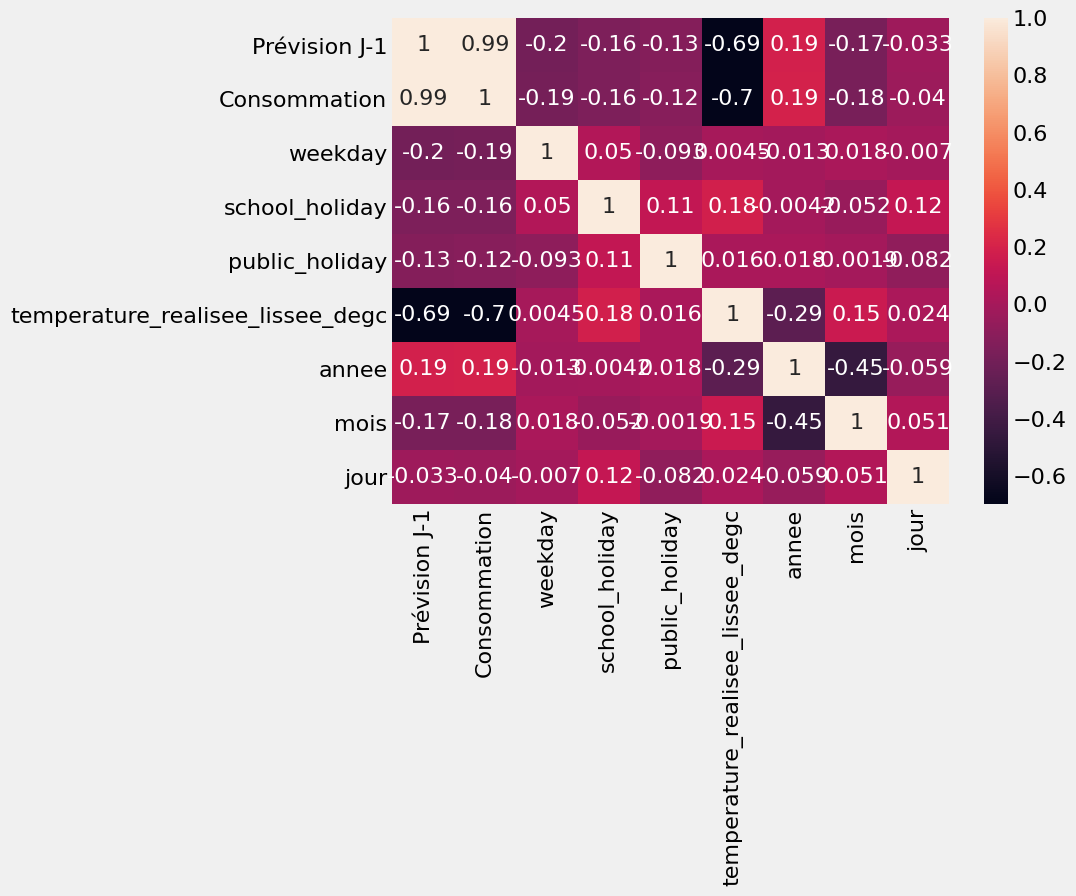

In [21]:
plt.figure(figsize=(8, 6))
sns.heatmap(df_final.corr(method="pearson"), annot=True)
plt.show()

# Machine Learning

## Preprocessing pour ML

In [22]:
df_final['hour'] = df_final['date_hour'].map(lambda x: x.hour)
df_final['minute'] = df_final['date_hour'].map(lambda x: x.minute)
df_final.drop(columns='date_hour',inplace=True)
df_final.drop(columns='Date',inplace=True)
df_final.drop(columns='Heures',inplace=True)
df_final

,Prévision J-1,Consommation,weekday,school_holiday,public_holiday,temperature_realisee_lissee_degc,annee,mois,jour,Type de jour TEMPO,hour,minute
0,44800.0,44940.0,2,0,0,15.9,2022,6,1,BLANC,0,0
1,42600.0,42514.0,2,0,0,15.9,2022,6,1,BLANC,0,30
2,40300.0,40359.0,2,0,0,15.8,2022,6,1,BLANC,1,0
3,40500.0,40049.0,2,0,0,15.8,2022,6,1,BLANC,1,30
4,40200.0,39328.0,2,0,0,15.7,2022,6,1,BLANC,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
28601,71200.0,67515.0,2,0,0,4.8,2024,1,17,BLANC,20,30
28602,69100.0,65217.0,2,0,0,4.8,2024,1,17,BLANC,21,0
28603,67300.0,63881.0,2,0,0,4.8,2024,1,17,BLANC,21,30
28604,66000.0,62791.0,2,0,0,4.8,2024,1,17,BLANC,22,0


## OneHotEncoder TEMPO

In [23]:
from sklearn.preprocessing import OneHotEncoder
# Instantiate the OneHotEncoder
ohe = OneHotEncoder(sparse =False)

# Fit encoder
ohe.fit(df_final[['Type de jour TEMPO']])

# Display the detected categories
print(f"The categories detected by the OneHotEncoder are {ohe.categories_}")

# Transform the current "Street" column
df_final[ohe.get_feature_names_out()] = ohe.transform(df_final[['Type de jour TEMPO']])

# Drop the column "Street" which has been encoded
df_final.drop(columns = ["Type de jour TEMPO"], inplace = True)

# Show the dataset
df_final.head(3)

The categories detected by the OneHotEncoder are [array(['BLANC', 'BLEU', 'ROUGE'], dtype=object)]


/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Prévision J-1,Consommation,weekday,school_holiday,public_holiday,temperature_realisee_lissee_degc,annee,mois,jour,hour,minute,Type de jour TEMPO_BLANC,Type de jour TEMPO_BLEU,Type de jour TEMPO_ROUGE
0,44800.0,44940.0,2,0,0,15.9,2022,6,1,0,0,1.0,0.0,0.0
1,42600.0,42514.0,2,0,0,15.9,2022,6,1,0,30,1.0,0.0,0.0
2,40300.0,40359.0,2,0,0,15.8,2022,6,1,1,0,1.0,0.0,0.0


## Train Test Split

In [24]:
n = 48 #Prédiction de 48h avant // conso_final_TR_merged.shape[0]

train = df_final.iloc[:-48]
test = df_final.iloc[-48:]

X_train = train.drop(columns='Consommation')
y_train = train.Consommation

X_test = test.drop(columns='Consommation')
y_test = test.Consommation

print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(28558, 13) (48, 13) (28558,) (48,)


## Scaling

In [25]:
# Step 0 - Instanciate Robust Scale
rb_scaler = RobustScaler()

# Step 1- Fit the scaler
rb_scaler.fit(X_train)

# 2-Scale/Transform
X_train_scaled = rb_scaler.transform(X_train)
X_test_scaled = rb_scaler.transform(X_test)

#Possibilité de faire une Pipeline au besoin si
# l'on souhaite appliquer des scaleurs précis

## Modélisation 1 : HistGradientBoostingRegressor

/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_4827/4137999545.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predictions"] = regressor.predict(X_test_scaled)


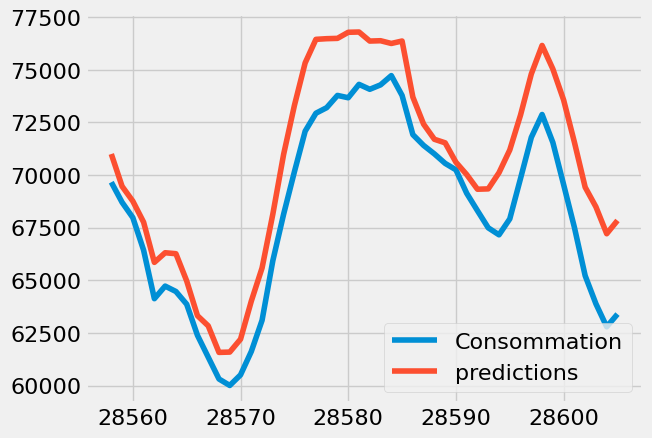

In [26]:
#0.6sec
regressor = HistGradientBoostingRegressor(min_samples_leaf=1)
regressor.fit(X_train_scaled, y_train)

test["predictions"] = regressor.predict(X_test_scaled)
test[['Consommation','predictions']].plot();

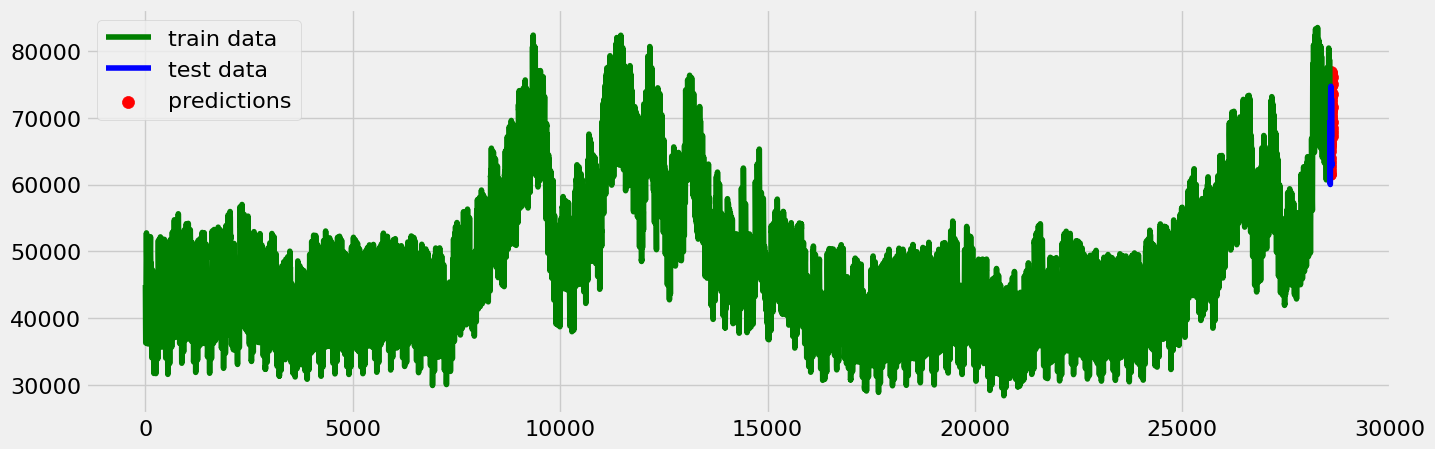

In [27]:
#Fig Globale
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(train.index,train["Consommation"], label='train data', color="green")
ax.plot(test.index,test["Consommation"], label='test data', color="blue")
#ax.plot(test.index, test["predictions"],  label='predictions', color="red")
ax.scatter(test.index, test["predictions"], label='predictions', color="red", s=75)
ax.legend(loc="upper left")
plt.show();

In [28]:
print('MSE = %.4g' % mean_squared_error(test["Consommation"],test["predictions"]))
print('MSE = %.4g' % mean_absolute_percentage_error(test["Consommation"],test["predictions"]))

MSE = 6.615e+06
MSE = 0.03387


Conlusion :
    - Bon modèle dans notre cas car le maximum situé au milie de la courbe lui donne une "référence" de cette zone de consommation. Dans le cas ou il n irait pas aussi haut, la courbe est restreinte au maximum qu'il a rencontré dans le train (exemple ci dessous)

#### Exemple Train trop faible

/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_4827/4146992741.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predictions_less_data"] = regressor.predict(X_test_scaled)


<AxesSubplot:>

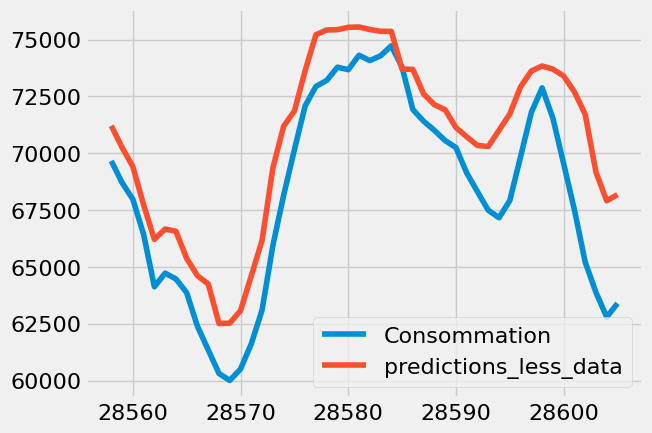

In [29]:
regressor = HistGradientBoostingRegressor(min_samples_leaf=1)
regressor.fit(X_train_scaled[20000:], y_train[20000:])

test["predictions_less_data"] = regressor.predict(X_test_scaled)
test[['Consommation','predictions_less_data']].plot()

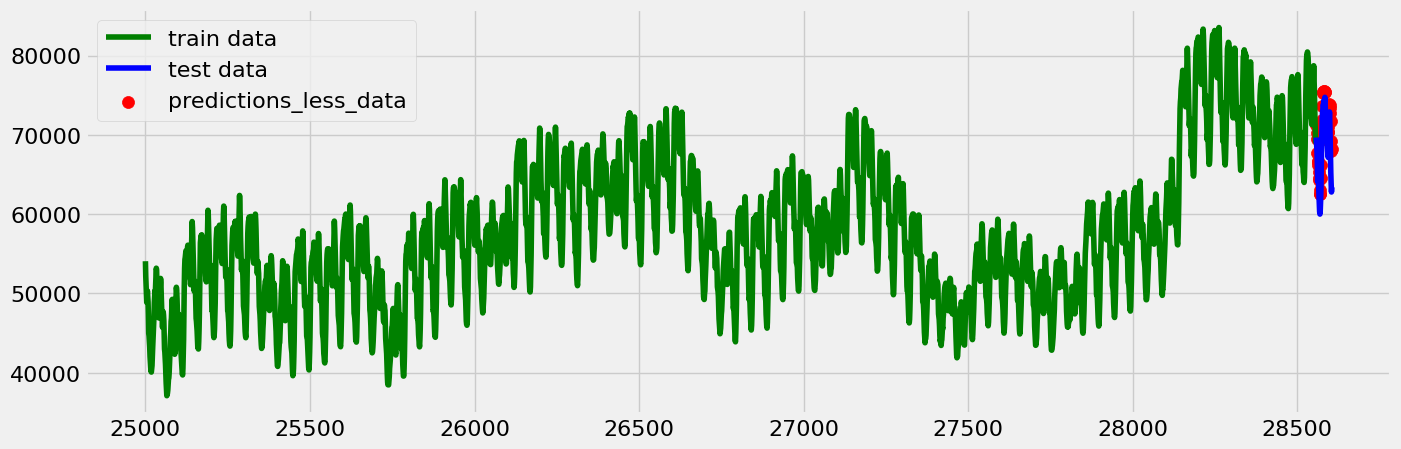

In [30]:
train_zoom = train[25000:]
test_zoom = test[:]

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(train_zoom.index,train_zoom["Consommation"], label='train data', color="green")
ax.plot(test_zoom.index,test_zoom["Consommation"], label='test data', color="blue")
#ax.plot(test.index, test["predictions"],  label='predictions', color="red")
ax.scatter(test_zoom.index, test_zoom["predictions_less_data"], label='predictions_less_data', color="red", s=75)
ax.legend(loc="upper left")
plt.show();

In [31]:
print('MSE = %.4g' % mean_squared_error(test["Consommation"],test["predictions_less_data"]))
print('MSE = %.4g' % mean_absolute_percentage_error(test["Consommation"],test["predictions_less_data"]))

MSE = 7.33e+06
MSE = 0.03534


## Modélisation 2 : avec LinearBoostRegressor

https://github.com/cerlymarco/linear-tree

In [32]:
regressor = LinearBoostRegressor(base_estimator=LinearRegression(),
                                 n_estimators = 300,
                                 max_depth    = 5,
                                 random_state = 42)

regressor.fit(X_train_scaled, y_train)
test["predictions_Linear"] = regressor.predict(X_test_scaled)

/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_4827/3773828757.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predictions_Linear"] = regressor.predict(X_test_scaled)


<AxesSubplot:>

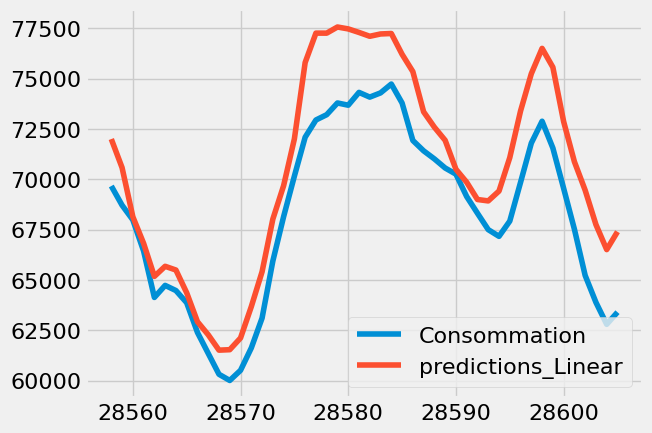

In [33]:
test[['Consommation','predictions_Linear']].plot()

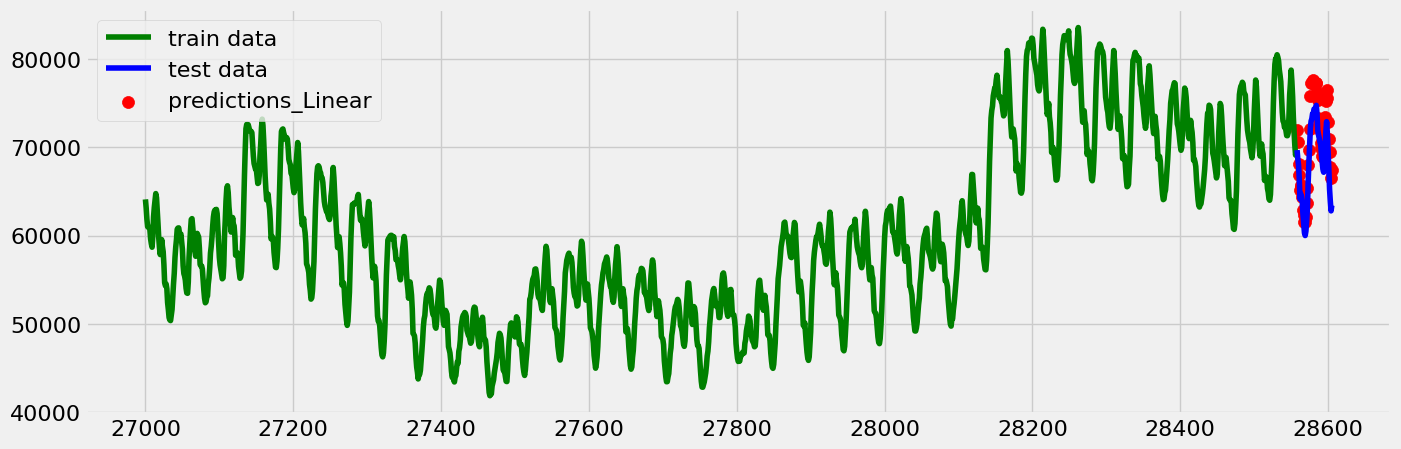

In [34]:
#Zoom sur l'ensemble
train_zoom = train[27000:]
test_zoom = test[:]

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(train_zoom.index,train_zoom["Consommation"], label='train data', color="green")
ax.plot(test_zoom.index,test_zoom["Consommation"], label='test data', color="blue")
#ax.plot(test.index, test["predictions"],  label='predictions', color="red")
ax.scatter(test_zoom.index, test_zoom["predictions_Linear"], label='predictions_Linear', color="red", s=75)
ax.legend(loc="upper left")
plt.show();

In [35]:
print('MSE = %.4g' % mean_squared_error(test["Consommation"],test["predictions_Linear"]))
print('MSE = %.4g' % mean_absolute_percentage_error(test["Consommation"],test["predictions_Linear"]))

MSE = 6.916e+06
MSE = 0.03364


#### Exemple Train trop faible

In [36]:
regressor = LinearBoostRegressor(base_estimator=LinearRegression(),
                                 n_estimators = 300,
                                 max_depth    = 5,
                                 random_state = 42)

regressor.fit(X_train_scaled[20000:], y_train[20000:])
test["predictions_Linear_less_data"] = regressor.predict(X_test_scaled)

/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_4827/4139210049.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predictions_Linear_less_data"] = regressor.predict(X_test_scaled)


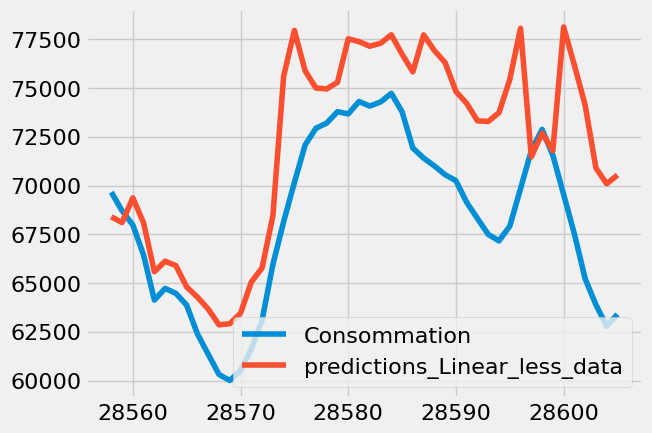

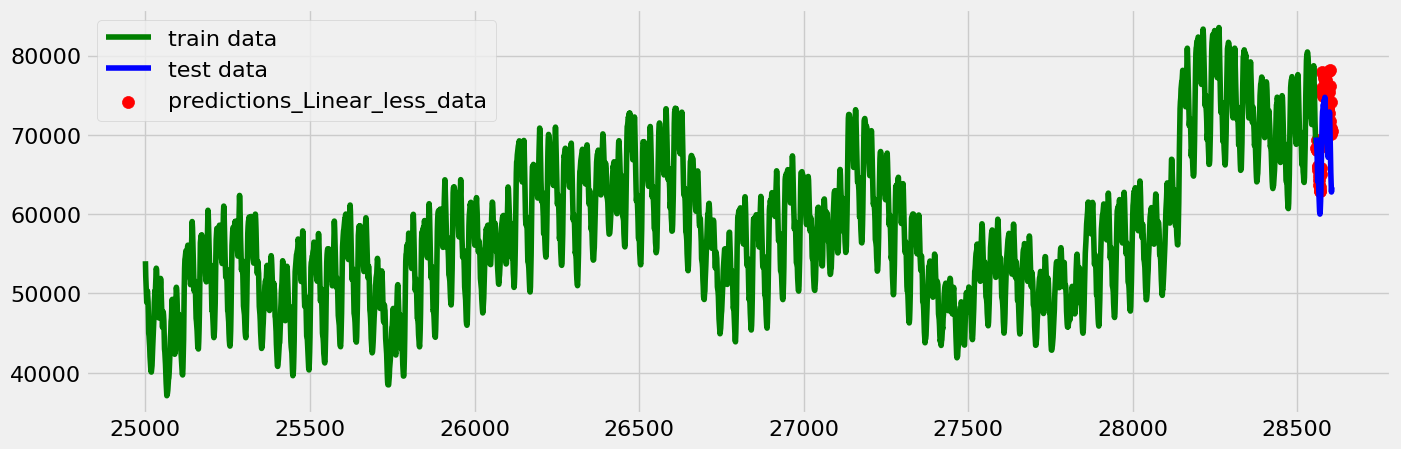

In [37]:
test[['Consommation','predictions_Linear_less_data']].plot()

#Avec Zoom
train_zoom = train[25000:]
test_zoom = test[:]

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(train_zoom.index,train_zoom["Consommation"], label='train data', color="green")
ax.plot(test_zoom.index,test_zoom["Consommation"], label='test data', color="blue")
#ax.plot(test.index, test["predictions"],  label='predictions', color="red")
ax.scatter(test_zoom.index, test_zoom["predictions_Linear_less_data"], label='predictions_Linear_less_data', color="red", s=75)
ax.legend(loc="upper left")
plt.show();

In [38]:
print('MSE = %.4g' % mean_squared_error(test["Consommation"],test["predictions_Linear_less_data"]))
print('MSE = %.4g' % mean_absolute_percentage_error(test["Consommation"],test["predictions_Linear_less_data"]))

MSE = 2.188e+07
MSE = 0.05766


## Conclusion

Tout d'abord, il est intéresasnt de se poser quelques questions afin d'améliorer l'ensemble :
- l'utilisation d'un request.get permet d'automatiser (coté ENEDIS et RTE)
- Analyser d'autres algorythmes de ML pour voir si certains ne sont pas plus performant. En effet, l'ajout de plus de colonnes necessite possiblement un autre type d'algorythme + un preproc différent.
  - Si les colonnes sont trop importantes, une colonne permutation pourrait être ue solution afin de dominuer la dimension

Ensuite, résultat très précis (trop?), valider s'il n'y a pas un data leak quelque part ou une erreur (<5% erreur très faible).

De nouvelles caractéristiques pourrraient être intégrer :
- prix de l'énergie électrique (tendance à moins se chauffer si prix élevé / à faire attention)

